In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class InfoArch:
    def __init__(self, root):
        self.root = root
    
    def treemap_plot(self, labels=None):
        arr = self.root.to_array()
        plt.imshow(arr, cmap='Paired', vmax=12)
#         plt.colorbar()
        if labels is not None:
            for i, lab in enumerate(labels):
                print(i, lab)
                indices = np.vstack(np.argwhere(arr == i))
                top_left = indices.argmin(axis=0)
                bottom_right = indices.argmax(axis=0)
                avg = (top_left + bottom_right) / 2
                plt.text(avg[0], avg[1], lab, ha='center')
    
        
class Node:
    def __init__(self, parent, components, height, width, priority):
        self.parent = parent
        self.components = components
        self.children = []
        self.height = height
        self.width = width
        self.priority = priority
    
    def add_child(self, node, idx):
        self.children.insert(idx, node)
    
    def split_node(self, max_splits=2, min_length=2):
        if len(self.components) > 1:
            print(f"Splitting components {self.components}")
            denom = np.sum([1 / (i + 1) for i in range(max_splits)])
            probs = np.array([(1 / (i + 1)) / denom for i in range(max_splits)])
            n_splits = max(np.random.choice(min(len(components), max_splits), size=1, p=probs), 1)
            if type(n_splits) != int:
                n_splits = n_splits[0]
            
            n_children = n_splits + 1
            new_children = np.arange(n_children)
            ids = np.random.permutation(new_children)
            n_to_draw = len(self.components) - n_children
            extra_ids = np.random.choice(new_children, n_to_draw)
            ids = np.append(ids, extra_ids)
            print(ids)
            
            if self.height > self.width:
                # split vertically
                heights, priorities = _divide1d(self.height, n_splits, min_length=min_length)
                dims = [(h, self.width, p) for h, p in zip(heights, priorities)]
            else:
                widths, priorities = _divide1d(self.width, n_splits, min_length=min_length)
                dims = [(self.height, w, p) for w, p in zip(widths, priorities)]

            for i in range(n_splits + 1):
                node = Node(self, self.components[ids == i], *dims[i])
                node.split_node()
                self.add_child(node, priorities[i])
    
    def __str__(self):
        if len(self.children) == 0:
            return f'{self.components}, {self.height, self.width}, {self.priority}'
        else:
            lines = [f'[]{self.height, self.width}, {self.priority}']
            for child in self.children:
                childstr = str(child)
                for i, line in enumerate(childstr.split('\n')):
                    if i == 0:
                        lines.append(f'|----{line}')
                    else:
                        lines.append(f'|    {line}')
                        
            return '\n'.join(lines)

    def to_array(self):
        if len(self.children) == 0:
            return np.full((self.height, self.width), self.components[0])
        else:
            arrs = [c.to_array() for c in self.children]
            heights = [a.shape[0] for a in arrs]
            if all([h == heights[0] for h in heights]):
                res = np.hstack(arrs)
            else:
                res = np.vstack(arrs)
            return res.reshape(self.height, self.width)
    
    def get_priorities(self):
        if len(self.children) == 0:
            return np.array([self.components[0], self.priority])
        else:
            res = []
            for child in self.children:
                res.append(child.get_priorities())
            res = np.vstack(res)
            res = res[np.argsort(res[:, 0])]
            res[:, 1] += self.priority
            return res


def _divide1d(length, n_splits, min_length=1):
    splits = np.random.choice(np.arange(1, length), size=n_splits)
    res = np.concatenate(([0], sorted(splits), [length]))
    cell_sizes = np.diff(res)
    # Compute priorities
    priorities = np.argsort(cell_sizes)
    return cell_sizes, priorities

In [3]:
components = np.array([1, 2, 3, 4, 5, 6, 7, 8])
height = 16
width = 20
root = Node(None, components, height, width, 0)

In [4]:
root.split_node(min_length=5)

Splitting components [1 2 3 4 5 6 7 8]
[1 0 0 1 0 1 1 0]
Splitting components [2 3 5 8]
[1 0 0 1]
Splitting components [3 5]
[1 0]
Splitting components [2 8]
[0 1]
Splitting components [1 4 6 7]
[1 0 1 0]
Splitting components [4 7]
[1 0]
Splitting components [1 6]
[0 1]


In [5]:
print(root)

[](16, 20), 0
|----[](16, 5), 0
|    |----[](1, 5), 0
|    |    |----[4], (1, 1), 0
|    |    |----[7], (1, 4), 1
|    |----[](15, 5), 1
|    |    |----[1], (3, 5), 0
|    |    |----[6], (12, 5), 1
|----[](16, 15), 1
|    |----[](3, 15), 0
|    |    |----[3], (3, 5), 0
|    |    |----[5], (3, 10), 1
|    |----[](13, 15), 1
|    |    |----[8], (13, 5), 0
|    |    |----[2], (13, 10), 1


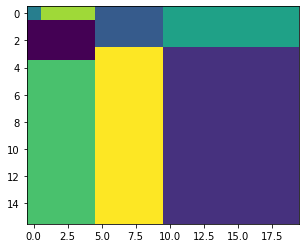

In [6]:
plt.imshow(root.to_array())

Now working on a class that allows you to pre-specify each component's position and size

In [7]:
# 12x12 grid
spec = [
    [[
        ([0], 6, 4),
        ([1], 4, 4)
    ],
    [
        ([2], 2, 8),
        [
            [
                ([4], 6, 4),
                ([5], 6, 4)
            ],
            ([3], 2, 8)
        ]
    ]],
    ([6], 2, 12)
]

In [8]:
def convert_to_tree(spec):
    if type(spec) == tuple:
        return Node(None, *spec, 0)
    else:
        nodes = [convert_to_tree(elem) for elem in spec]
        heights = np.array([n.height for n in nodes])
        widths = np.array([n.width for n in nodes])
        if all([h == heights[0] for h in heights]):
            # Split by width
            height = heights[0]
            width = widths.sum()
        else:
            # Split by height
            width = widths[0]
            height = heights.sum()
        
        sizes = [(s, idx) for idx, s in enumerate(heights + widths)]
        sizes = sorted(sizes, key=lambda x: (x[0], -x[1]))
        priorities = [(idx, p) for p, (_, idx) in enumerate(sizes)]
        priorities = sorted(priorities, key=lambda x: x[0])
        priorities = [p for idx, p in priorities]

        components = []
        new_node = Node(None, None, height, width, 0)
        for i, (n, p) in enumerate(zip(nodes, priorities)):
            n.priority = p
            new_node.add_child(n, i)
            components.extend(n.components)
        new_node.components = components
        return new_node

In [9]:
root = convert_to_tree(spec)
ia = InfoArch(root)

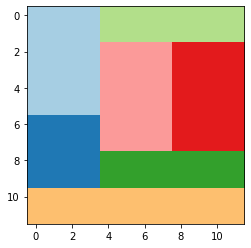

In [10]:
ia.treemap_plot()

In [11]:
root.components

[0, 1, 2, 4, 5, 3, 6]

Next steps:

1. Generate a bunch of reasonable trees
2. Compute a similarity function
3. Display them in a cluster to see which are the most similar as a sanity check

In [24]:
# 12x12 grid
spec1 = [
    [[
        ([0], 6, 4),
        ([1], 4, 4)
    ],
    [
        ([2], 2, 8),
        [
            [
                ([4], 6, 4),
                ([5], 6, 4)
            ],
            ([3], 2, 8)
        ]
    ]],
    ([6], 2, 12)
]
# 12x12 grid
spec2 = [
    [[
        ([0], 6, 4),
        ([1], 4, 4)
    ],
    [
        ([2], 2, 8),
        [
            [
                ([4], 6, 8),
            ],
            ([3], 2, 8)
        ]
    ]],
    ([5], 2, 12)
]

In [25]:
root1 = convert_to_tree(spec1)
root2 = convert_to_tree(spec2)

In [26]:
print(root2)

[](12, 12), 0
|----[](10, 12), 1
|    |----[](10, 4), 0
|    |    |----[0], (6, 4), 1
|    |    |----[1], (4, 4), 0
|    |----[](10, 8), 1
|    |    |----[2], (2, 8), 0
|    |    |----[](8, 8), 1
|    |    |    |----[](6, 8), 1
|    |    |    |    |----[4], (6, 8), 0
|    |    |    |----[3], (2, 8), 0
|----[5], (2, 12), 0


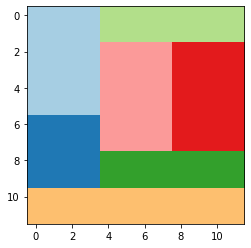

In [27]:
ia2 = InfoArch(root1)
ia2.treemap_plot()

In [16]:
root1.get_priorities()

array([[0, 2],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 5],
       [5, 4],
       [6, 0]])

In [17]:
root2.get_priorities()

array([[0, 2],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 0]])